In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [3]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [4]:
train = train[~((train['type']=='PM2.5')&(train['门头沟']>2000))]

In [5]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [6]:
train = preprocess(train)
test = preprocess(test)

In [7]:
def process_one_location(df, location, take_log=True, take_diff=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    subset_augmented = subset.asfreq('h')
#     subset_augmented = subset_augmented.interpolate(method = 'linear')

#     subset_augmented = subset_augmented.dropna()
    
#     if take_log:
#         subset_augmented = subset_augmented.apply(lambda x: np.log(x))
    if take_log:
        subset_augmented['PM2.5'] = subset_augmented['PM2.5'].map(lambda x: np.log(x))
        
    subset_augmented = feature_engineering(subset_augmented,n_lag,take_diff)
    
#     subset_augmented =  subset_augmented.dropna()
    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    
    if take_diff:
        subset_augmented['target'] = subset_augmented['PM2.5_diff']
        subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    else:
        subset_augmented['target'] = subset_augmented['PM2.5']
        subset_augmented = subset_augmented.drop(columns=['PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag, take_diff=True):
    if take_diff:
        subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
        subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
        subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
#         subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
        subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
#         subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
        subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
#         subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
        subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
#         subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented,take_diff)
    
    subset_augmented = calculate_rolling_stat(subset_augmented,take_diff)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for p in col:
        res[f'{p}_daily_mean'] = res[p].rolling(24,min_periods=1).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24,min_periods=1).median()
        res[f'{p}_daily_std'] = res[p].rolling(24,min_periods=1).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7,min_periods=1).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7,min_periods=1).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7,min_periods=1).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30,min_periods=1).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30,min_periods=1).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30,min_periods=1).std()
    return res

In [8]:
IS_TAKING_LOG=False
IS_TAKING_DIFF=True

In [10]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

In [10]:
#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

In [23]:
if IS_TAKING_DIFF:
    alldata = alldata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    alldata = alldata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

alldata = alldata[alldata.index>'2014-04-03']   #starting from April 3rd for complete data
allTarget = allTarget[allTarget.index>'2014-04-03']   #starting from April 3rd for complete data

In [34]:
def filter_na(data,true_y,locations):
    res = pd.DataFrame()
    res_test = pd.DataFrame()
    for l in locations:
        subset = data[data['location']==l]
        testing_y = true_y[true_y['location']==l]
        train_notna_index = subset['target'].notna()
        subset = subset[train_notna_index]
        testing_y = testing_y[train_notna_index]
        
        res = pd.concat([res,subset])
        res_test = pd.concat([res_test,testing_y])
    return res, res_test

In [31]:
alldata

,PM2.5_diff_lag_1,SO2_diff_lag_1,CO_diff_lag_1,NO2_diff_lag_1,O3_diff_lag_1,PM2.5_diff_lag_2,SO2_diff_lag_2,CO_diff_lag_2,NO2_diff_lag_2,O3_diff_lag_2,...,O3_diff_daily_median,O3_diff_daily_std,O3_diff_weekly_mean,O3_diff_weekly_median,O3_diff_weekly_std,O3_diff_monthly_mean,O3_diff_monthly_median,O3_diff_monthly_std,location,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-03 01:00:00,-4.0,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东四,-5.0
2014-04-03 02:00:00,-5.0,NaN,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东四,2.0
2014-04-03 03:00:00,2.0,NaN,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东四,-5.0
2014-04-03 04:00:00,-5.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东四,5.0
2014-04-03 05:00:00,5.0,NaN,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东四,-18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 05:00:00,1.0,-4.0,-1.4,-18.0,NaN,0.0,-6.0,-1.4,-30.0,18.0,...,11.0,11.774302,7.219512,3.0,22.600427,1.333333,0.0,24.686873,东四环,4.0
2016-12-29 06:00:00,4.0,-2.0,-1.3,-6.0,4.0,1.0,-4.0,-1.4,-18.0,NaN,...,11.0,11.123957,6.943089,3.0,22.353458,1.350970,0.0,24.689491,东四环,-4.0
2016-12-29 07:00:00,-4.0,2.0,-1.3,-7.0,10.0,4.0,-2.0,-1.3,-6.0,4.0,...,11.0,10.795622,6.650407,3.0,22.138529,1.361552,0.0,24.689767,东四环,6.0


In [35]:
alldata_noNA, allTarget_noNA = filter_na(alldata,allTarget,train.columns[1:])

In [43]:
if IS_TAKING_DIFF:
    allTestdata = allTestdata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    allTestdata = allTestdata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

allTestdata = allTestdata[allTestdata.index>='2017-01-01']
allTestTarget = allTestTarget[allTestTarget.index>='2017-01-01']

In [45]:
allTestdata_noNA, allTestTarget_noNA = filter_na(allTestdata,allTestTarget,train.columns[1:])

In [47]:
allTestTarget_noNA

,PM2.5,location,PM2.5_y
Datetime,,,
2017-01-01 23:00:00,470.0,东四,469.0
2017-01-02 00:00:00,458.0,东四,470.0
2017-01-02 01:00:00,477.0,东四,458.0
2017-01-02 02:00:00,467.0,东四,477.0
2017-01-02 03:00:00,405.0,东四,467.0
...,...,...,...
2017-04-29 19:00:00,59.0,东四环,36.0
2017-04-29 20:00:00,44.0,东四环,59.0
2017-04-29 21:00:00,56.0,东四环,44.0


In [48]:
alldata_noNA['location'] = alldata_noNA['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noNA['location'].cat.categories ) )
alldata_noNA['location'] = alldata_noNA['location'].cat.codes
allTestdata_noNA['location'] = allTestdata_noNA['location'].astype('category')
allTestdata_noNA['location'] = allTestdata_noNA['location'].cat.codes

In [64]:
allTestTarget_noNA

,PM2.5,location,PM2.5_y
Datetime,,,
2017-01-01 23:00:00,470.0,东四,469.0
2017-01-02 00:00:00,458.0,东四,470.0
2017-01-02 01:00:00,477.0,东四,458.0
2017-01-02 02:00:00,467.0,东四,477.0
2017-01-02 03:00:00,405.0,东四,467.0
...,...,...,...
2017-04-29 19:00:00,59.0,东四环,36.0
2017-04-29 20:00:00,44.0,东四环,59.0
2017-04-29 21:00:00,56.0,东四环,44.0


In [52]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [57]:
import lightgbm as lgb
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [58]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits
        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [59]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noNA,allTestdata_noNA,alldata_noNA['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	training's rmse: 14.9458	valid_1's rmse: 15.5789
val rmse score is 15.578916209285614
Fold: 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	training's rmse: 13.6235	valid_1's rmse: 20.5064
val rmse score is 20.50640688176727
Fold: 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	training's rmse: 17.3901	valid_1's rmse: 13.7735
val rmse score is 13.773530603399035
Fold: 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	training's rmse: 14.8706	valid_1's rmse: 20.5101
val rmse score is 20.510071421811748
Fold: 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[347]	training's rmse: 14.7425	valid_1's rmse: 15.0389
val rmse score is 15.038865138685521
mean rmse score over f

In [61]:
def process_prediction(predicted, true_y, take_log=True, take_diff=True):
    true_y['predicted'] = predicted
    if take_diff:
        true_y['prediction'] = true_y['predicted'] + true_y['PM2.5_y']
    else:
        true_y['prediction'] = true_y['predicted']
        
    true_y['prediction'] = true_y['prediction'].map(lambda x: max(x,0)) # floor at 0
    true_y['prediction'] = true_y['prediction'].map(lambda x: min(x,1000)) # cap at 1000
    
    if take_log:
        true_y['prediction']=true_y['prediction'].map(lambda x: np.exp(x))
        true_y['PM2.5_y']=true_y['PM2.5_y'].map(lambda x: np.exp(x))
        true_y['PM2.5']=true_y['PM2.5'].map(lambda x: np.exp(x))

    true_y.dropna(inplace=True)

In [65]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

In [66]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 17.262126580401432
Out of sample RMSE for LightGBM method is 20.170772308146567


In [67]:
print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [68]:
print('Out of sample RMSE for each location is')
display(allTestTarget_noNA.groupby(allTestTarget_noNA.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    24.940216
万柳      16.699598
东四      20.848639
东四环     18.589009
东高村     19.997583
丰台花园    18.272745
云岗      20.298991
亦庄      17.647525
八达岭     11.911778
农展馆     18.279543
前门      23.753276
北部新区    18.640470
南三环     25.053217
古城      22.056134
大兴      19.189076
天坛      18.923606
奥体中心    18.075371
官园      18.258230
定陵      14.782580
密云      15.945211
密云水库    12.871813
平谷      23.012071
延庆      17.759521
怀柔      17.440767
房山      20.771900
昌平      18.209852
植物园     16.221618
榆垡      28.560025
永乐店     21.566391
永定门内    25.716644
琉璃河     25.741198
西直门北    21.908320
通州      21.939465
门头沟     21.850970
顺义      19.147471
dtype: float64

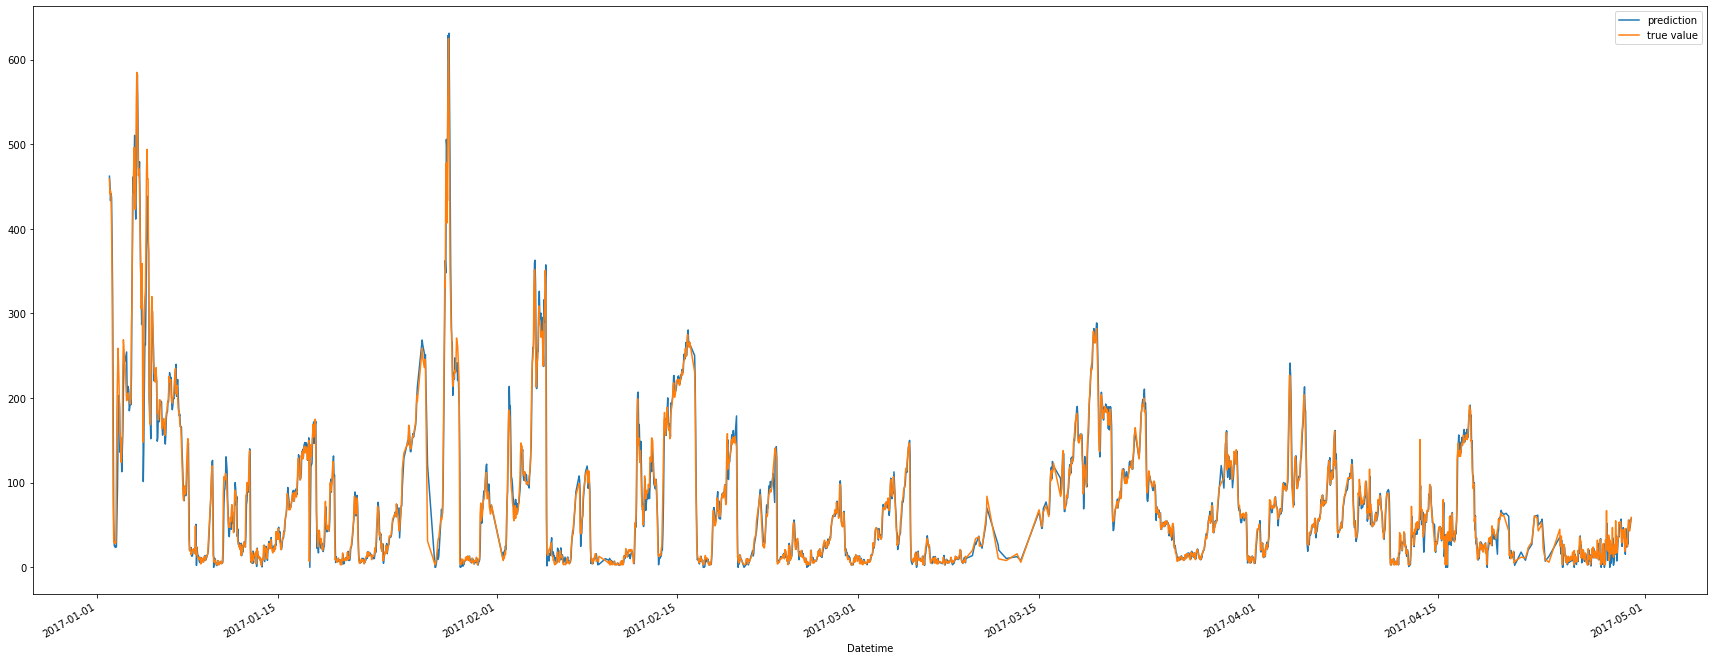

In [80]:
plt.figure(figsize=(30, 12))
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['prediction'].plot(label='prediction')
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['PM2.5'].plot(label='true value')
plt.legend()
plt.show()

In [81]:
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']

,PM2.5,location,PM2.5_y,predicted,prediction
Datetime,,,,,
2017-01-01 23:00:00,459.0,万柳,468.0,-5.773418,462.226582
2017-01-02 00:00:00,441.0,万柳,459.0,-5.931092,453.068908
2017-01-02 01:00:00,445.0,万柳,441.0,-7.667138,433.332862
2017-01-02 02:00:00,440.0,万柳,445.0,-3.155680,441.844320
2017-01-02 03:00:00,403.0,万柳,440.0,-3.272162,436.727838
...,...,...,...,...,...
2017-04-29 19:00:00,47.0,万柳,56.0,-0.191951,55.808049
2017-04-29 20:00:00,43.0,万柳,47.0,-0.712327,46.287673
2017-04-29 21:00:00,51.0,万柳,43.0,3.591798,46.591798


In [75]:
print('In sample RMSE for each location is')
display(allTarget_noNA.groupby(allTarget_noNA.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

In sample RMSE for each location is


location
万寿西宫    16.675132
万柳      15.548264
东四      16.437431
东四环     17.896841
东高村     15.869308
丰台花园    17.471228
云岗      15.948478
亦庄      18.576600
八达岭     12.574230
农展馆     16.394101
前门      19.738040
北部新区    15.578193
南三环     18.562719
古城      17.728725
大兴      19.042287
天坛      15.693212
奥体中心    16.731689
官园      15.796381
定陵      15.559675
密云      14.240541
密云水库    11.969323
平谷      17.854618
延庆      14.003830
怀柔      13.813617
房山      20.099903
昌平      17.195726
植物园     15.596426
榆垡      23.112207
永乐店     21.344105
永定门内    18.063505
琉璃河     24.063610
西直门北    18.071382
通州      19.223097
门头沟     14.039139
顺义      17.134983
dtype: float64